Loading input files from Colab working directory...
LOCATIONS: 357 rows
PARTS    : 67 rows
BASELINE : 174 occupied bins

[Dashboard] Generating Baseline (Input) dashboard...

==================== PROCESSING: Baseline (Input) ====================

---------- Baseline (Input) ----------
Weight Violations        : 0 (OK)
Misplaced A-Items        : 17 (!)

--- Scoring Breakdown (Avg per Occupied Bin) ---
Avg Combined Score       : 261.0
  > Zone Reward          : 27.6
  > Util Reward          : 285.2
  > Dist Penalty         : -51.8

Avg Util (Occupied)      : 35.65%
%Occupied Bins           : 48.7%   (174/357)
---------------------------------------------

[Visualizer] Plot saved to: /content/plots/plot_001_top_view_baseline_(input).png


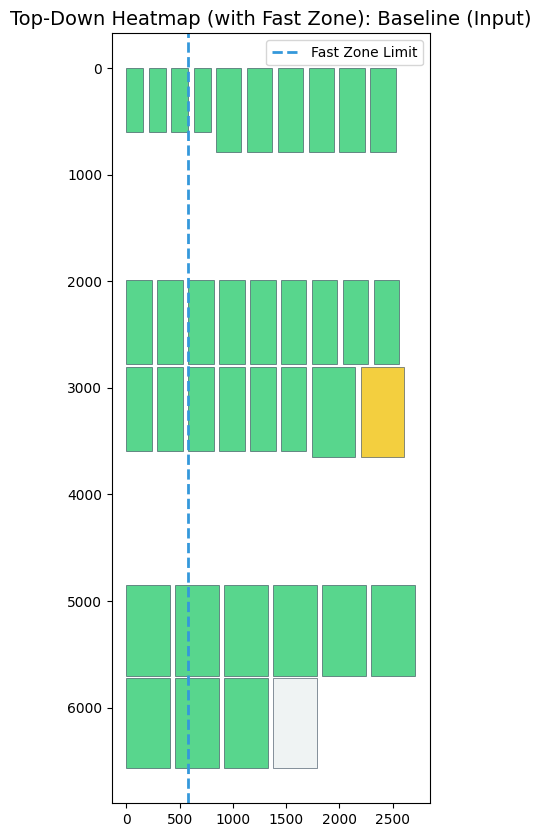

[Visualizer] Plot saved to: /content/plots/plot_002_front_view_baseline_(input).png


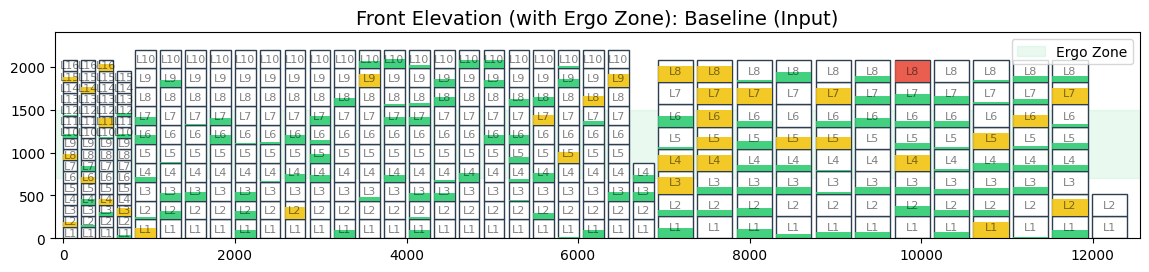

[Visualizer] Plot saved to: /content/plots/plot_003_scatter_demand_height_baseline_(input).png


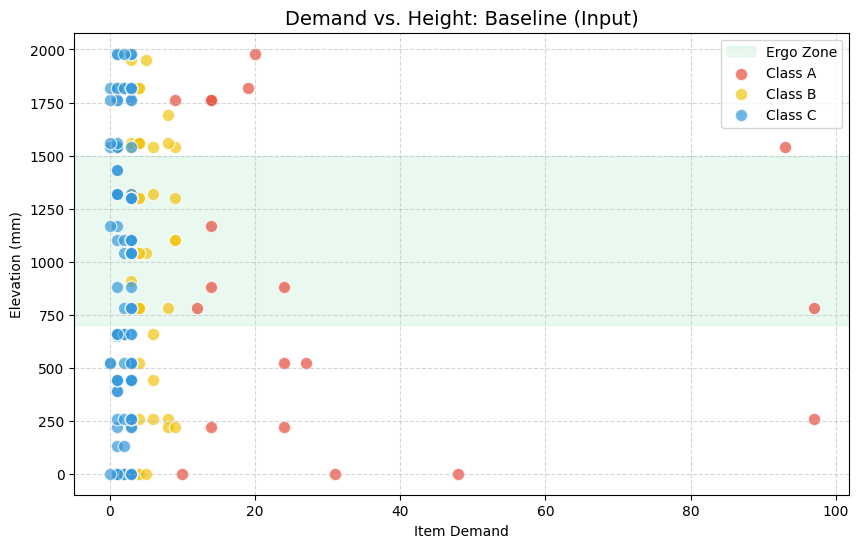

[Visualizer] Plot saved to: /content/plots/plot_004_hist_utilization_baseline_(input).png


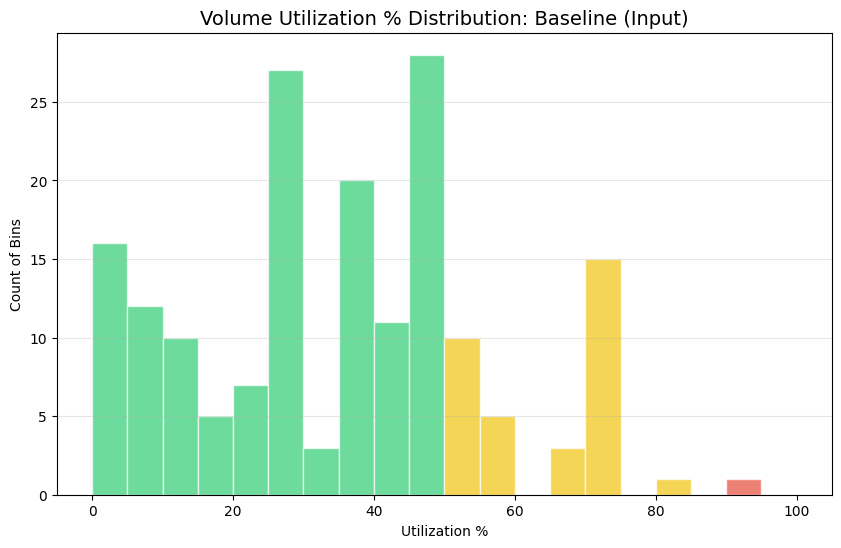


Training RL (Guide-parity reward, zone actions, box-level)...

Generating optimized allocation (BOX-LEVEL, single SKU per bin, SKU can span bins)...
Placed bins: 180
Coverage OK: all SKUs with BOXES_ON_HAND>0 were fully allocated.

Building validated output CSV (authoritative geometry + volumes)...
[OK] Saved optimized allocations to: /content/allocations_rl_optimized.csv
  loc_inst_code LOCATION_TYPE   ITEM_ID  QTY_ALLOCATED  MAX_UNITS  GRID_X  \
0      A1-00001           BIN  15210243              2          2       1   
1      A1-00002           BIN  15210243              2          2       1   
2      A1-00003           BIN  15210243              2          2       1   
3      A1-00004           BIN  15210243              2          2       1   
4      A1-00005           BIN  15210243              2          2       1   
5      A1-00006           BIN  15210243              2          2       1   
6      A1-00007           BIN  14891290              6          6       1   
7      A

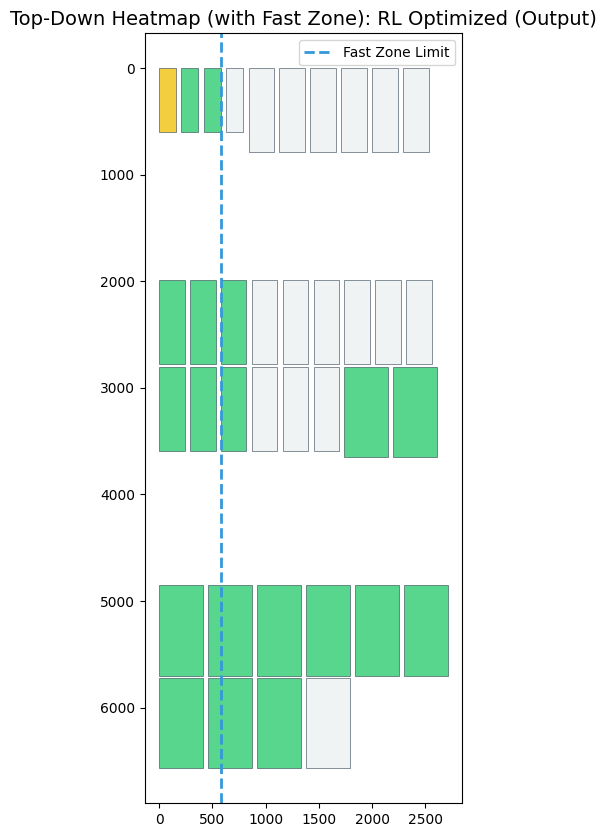

[Visualizer] Plot saved to: /content/plots/plot_006_front_view_rl_optimized_(output).png


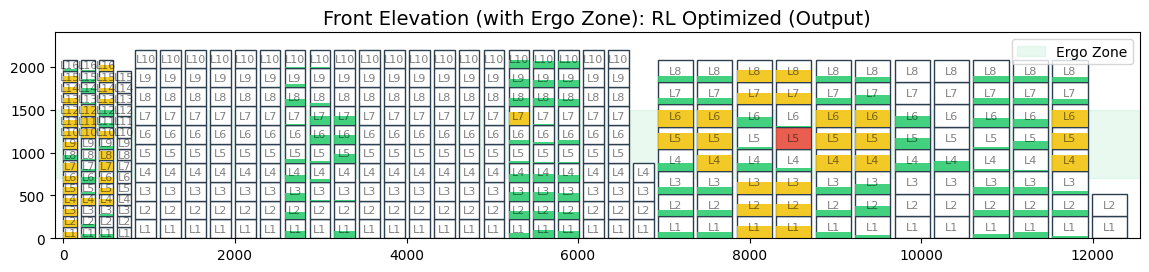

[Visualizer] Plot saved to: /content/plots/plot_007_scatter_demand_height_rl_optimized_(output).png


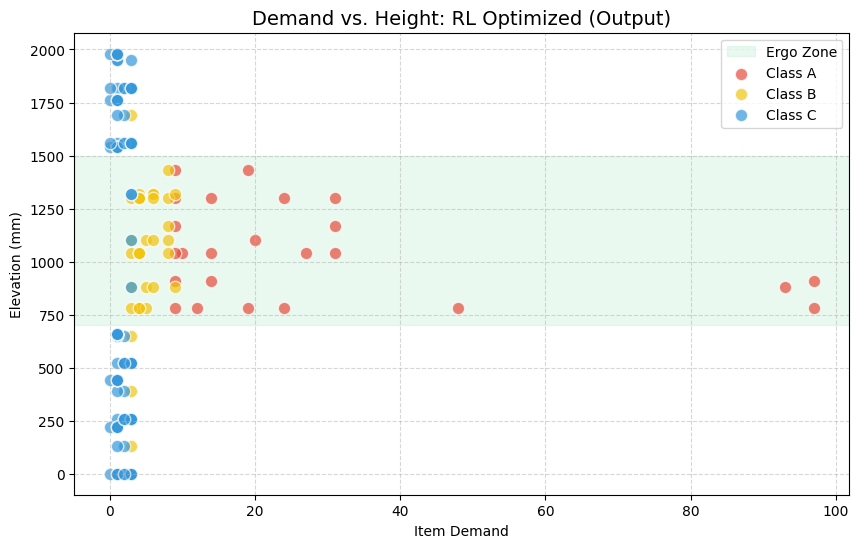

[Visualizer] Plot saved to: /content/plots/plot_008_hist_utilization_rl_optimized_(output).png


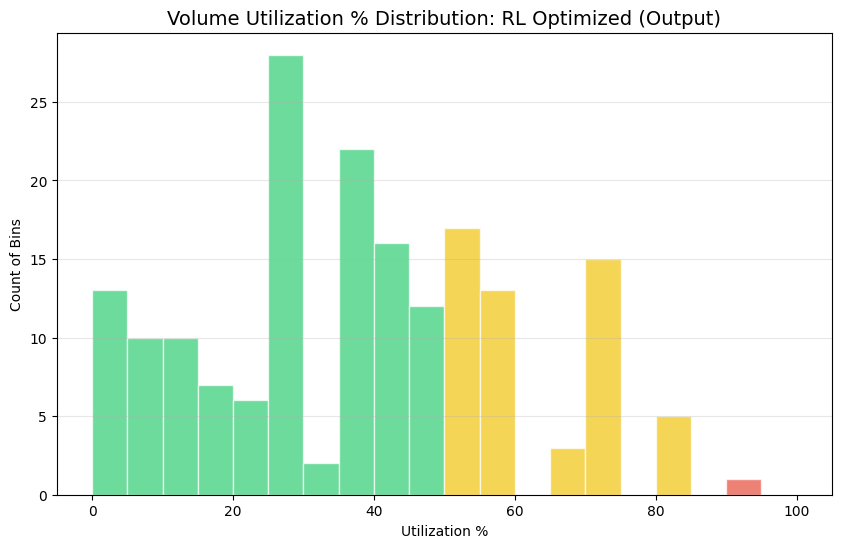


Done.


In [1]:
import os
import math
import random
import numpy as np
import pandas as pd
import importlib.util

# -----------------------------
# 0) Robust local imports
# -----------------------------
def import_from_path(module_name: str, path: str):
    spec = importlib.util.spec_from_file_location(module_name, path)
    mod = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(mod)  # type: ignore
    return mod

# Change the path of all the input files when using different files
GEOM = import_from_path("geometry", "/content/geometry.py")
DIST = import_from_path("distance", "/content/distance.py")
VIZ  = import_from_path("metrics_viz_lib", "/content/metrics_viz_lib.py")

# -----------------------------
# 1) File configuration
# -----------------------------
ALLOC_BASELINE_FILE = "/content/allocations_prototype.csv"
LOCATIONS_FILE      = "/content/locations_dummy_prototype.csv"
PARTS_FILE          = "/content/synthetic_parts_generated_prototype.csv"
OUTPUT_ALLOC_FILE   = "/content/allocations_rl_optimized.csv"

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# ---------------------------------
# 2) Loading + schema harmonization
# ---------------------------------
def read_csv_semicolon_if_needed(path: str) -> pd.DataFrame:
    try:
        return pd.read_csv(path, sep=None, engine="python")
    except Exception:
        return pd.read_csv(path, sep=";")

# Normalize and validate warehouse location data and compute derived geometric attributes.
def normalize_locations(df_loc: pd.DataFrame) -> pd.DataFrame:
    df = df_loc.copy()
    df.columns = df.columns.str.strip()

    required = ["loc_inst_code", "width", "depth", "height", "x", "y", "z"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"locations_dummy.csv missing columns: {missing}")

    df["loc_inst_code"] = df["loc_inst_code"].astype(str)

    if "LOCATION_TYPE" not in df.columns:
        df["LOCATION_TYPE"] = "BIN"

    for c in ["width", "depth", "height", "x", "y", "z"]:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0.0)

    df["LOCATION_VOL_MM3"] = (df["width"] * df["depth"] * df["height"]).astype(float)

    # Optional: row/bay/level (if present, we keep for affinity neighbor logic)
    for c in ["row_num", "bay_num", "level_num"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    return df

# Normalize and enrich part master data with demand, volume, and safety attributes.
def normalize_parts(df_parts: pd.DataFrame) -> pd.DataFrame:
    df = df_parts.copy()
    df.columns = df.columns.str.strip()

    required = ["ITEM_ID", "LEN_MM", "WID_MM", "DEP_MM", "WT_KG", "BOXES_ON_HAND"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"synthetic_parts_generated.csv missing columns: {missing}")

    df["ITEM_ID"] = df["ITEM_ID"].astype(str)

    for c in ["LEN_MM", "WID_MM", "DEP_MM", "WT_KG", "BOXES_ON_HAND"]:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0.0)

    if "DEMAND" not in df.columns:
        df["DEMAND"] = df["BOXES_ON_HAND"].astype(float)
    else:
        df["DEMAND"] = pd.to_numeric(df["DEMAND"], errors="coerce").fillna(0.0)

    if "QTY_PER_BOX" not in df.columns:
        df["QTY_PER_BOX"] = 1

    df["UNIT_VOL_MM3"] = (df["LEN_MM"] * df["WID_MM"] * df["DEP_MM"]).astype(float)
    df["IS_HEAVY"] = df["WT_KG"] > 15.0  # Guide: heavy items if WT_KG > 15kg

    return df

# Standardizes the baseline allocation schema and enforces one-SKU-per-bin input consistency.
def normalize_allocations_baseline(df_alloc: pd.DataFrame) -> pd.DataFrame:
    """
    Baseline is used only for:
      - baseline dashboard display
      - old_bin reference (movement distance between old/new is not part of guide score,
        but we keep old_bin for optional tie-breakers if needed)
    We also sanitize single row per bin (if baseline violated).
    """
    df = df_alloc.copy()
    df.columns = df.columns.str.strip()

    rename_map = {}
    if "LOCATION_ID" in df.columns and "loc_inst_code" not in df.columns:
        rename_map["LOCATION_ID"] = "loc_inst_code"
    if "LOC_CODE" in df.columns and "loc_inst_code" not in df.columns:
        rename_map["LOC_CODE"] = "loc_inst_code"
    if "SKU" in df.columns and "ITEM_ID" not in df.columns:
        rename_map["SKU"] = "ITEM_ID"
    if "QTY" in df.columns and "QTY_ALLOCATED" not in df.columns:
        rename_map["QTY"] = "QTY_ALLOCATED"
    if "UNITS_ALLOCATED" in df.columns and "QTY_ALLOCATED" not in df.columns:
        rename_map["UNITS_ALLOCATED"] = "QTY_ALLOCATED"
    if rename_map:
        df = df.rename(columns=rename_map)

    required = ["loc_inst_code", "ITEM_ID", "QTY_ALLOCATED"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(
            f"allocations.csv must contain {required}. Missing: {missing}. "
            f"Columns found: {list(df.columns)}"
        )

    df["loc_inst_code"] = df["loc_inst_code"].astype(str)
    df["ITEM_ID"] = df["ITEM_ID"].astype(str)
    df["QTY_ALLOCATED"] = pd.to_numeric(df["QTY_ALLOCATED"], errors="coerce").fillna(0).astype(int)

    # Enforce single SKU per bin in baseline state (if baseline violates, keep first)
    df = df.sort_values(["loc_inst_code"]).drop_duplicates(subset=["loc_inst_code"], keep="first")
    df = df[df["QTY_ALLOCATED"] > 0].copy()

    return df[["loc_inst_code", "ITEM_ID", "QTY_ALLOCATED"]]

# ----------------------------------------------
# 3) Geometry wrapper (ONLY via input library)
# ----------------------------------------------
def geom_solve_capacity_and_layout(loc_row: pd.Series, part_row: pd.Series, qty: int):
    # This wrapper handles both Series and Dict inputs because optimizations convert rows to Dicts
    loc_dims = [float(loc_row["width"]), float(loc_row["depth"]), float(loc_row["height"])]
    sku_dims = [float(part_row["LEN_MM"]), float(part_row["WID_MM"]), float(part_row["DEP_MM"])]

    max_units, best_orient, grid = GEOM.compute_layered_capacity(loc_dims, sku_dims)
    if max_units <= 0 or best_orient is None:
        return None

    if qty > max_units:
        return None

    gx, gy, gz = grid
    ox, oy, oz = best_orient

    full_layers, units_per_layer, partial_units = GEOM.compute_actual_layout(qty, grid)

    return {
        "MAX_UNITS": int(max_units),
        "GRID_X": int(gx),
        "GRID_Y": int(gy),
        "GRID_Z": int(gz),
        "ORIENT_X_MM": float(ox),
        "ORIENT_Y_MM": float(oy),
        "ORIENT_Z_MM": float(oz),
        "FULL_LAYERS": int(full_layers),
        "PARTIAL_UNITS": int(partial_units),
    }

# ------------------------------------
# 4) GUIDE PRE-PROCESSING
# ------------------------------------

# Applies demand-based Dynamic ABC classification and flags heavy items to support priority-aware slotting and safety constraints.
def apply_dynamic_abc(df_parts: pd.DataFrame) -> pd.DataFrame:
    """
    STRICT parity:
      - A = top 20% by DEMAND (floor/int)
      - B = next 30% (until 50%)
      - C = rest
      - Heavy = WT_KG > 15kg
    """
    df = df_parts.copy()
    df["ITEM_ID"] = df["ITEM_ID"].astype(str)

    df = df.sort_values("DEMAND", ascending=False).reset_index(drop=True)
    n = len(df)

    if n == 0:
        df["ABC_CLASS"] = "C"
        df["IS_HEAVY"] = False
        return df

    # floor style
    a_cut = int(n * 0.20)
    b_cut = int(n * 0.50)

    # safety for tiny datasets
    if a_cut == 0 and n > 0:
        a_cut = 1
    if b_cut < a_cut:
        b_cut = a_cut

    abc = []
    for i in range(n):
        if i < a_cut:
            abc.append("A")
        elif i < b_cut:
            abc.append("B")
        else:
            abc.append("C")

    df["ABC_CLASS"] = abc
    df["IS_HEAVY"] = (pd.to_numeric(df["WT_KG"], errors="coerce").fillna(0.0) > 15.0)

    return df


# Defines warehouse macro-zones (Fast and Ergonomic), computes the entrance reference point, and derives distance normalization constants for reward calculation.
def build_guide_zones(df_loc: pd.DataFrame):
    """
    Guide zones:
      - Entrance: X=0, Y=maxY/2, Z=0
      - Fast zone: X <= 0.25 * MAX(X)
      - Ergo zone: 700 <= Z <= 1500
    Also returns:
      - max_dist_possible used for distance penalty normalization (-100..0)
      - max_x_dim (kept because main passes it)
    """
    df = df_loc.copy()
    df["loc_inst_code"] = df["loc_inst_code"].astype(str)

    max_x = float(df["x"].max() if df["x"].max() > 0 else 1.0)
    max_y = float(df["y"].max() if df["y"].max() > 0 else 0.0)

    entrance = {"x": 0.0, "y": max_y / 2.0, "z": 0.0}

    fast_x_limit = 0.25 * max_x
    df["IS_FAST_ZONE"] = (df["x"] <= fast_x_limit)
    df["IS_ERGO_ZONE"] = df["z"].between(700.0, 1500.0)

    # A reasonable "max possible" for manhattan distance from entrance
    # furthest x + furthest y deviation from mid
    max_dist_possible = float(max_x + (max_y / 2.0))
    if max_dist_possible <= 0:
        max_dist_possible = 1.0

    max_x_dim = max_x
    return df, entrance, max_dist_possible, max_x_dim


# ---------------------------------------------------
# 5) RLRelocator (BOX-LEVEL)
# ---------------------------------------------------
class RLRelocator:
    """
    BOX-LEVEL placement:
      - Places exactly 1 box per decision.
      - Single SKU per bin (no mixed storage).
      - Same SKU can occupy multiple bins (overflow allowed).
      - Uses 4 actions = zone combos:
          0: Fast+Ergo
          1: Fast+NonErgo
          2: NonFast+Ergo
          3: NonFast+NonErgo

    Reward/Score:
      Illegal => -10000 if:
        - geometry fit is False  (geom_pack None)
        - heavy AND z > 1500mm
      Else:
        ZoneReward + UtilReward + DistancePenalty + AffinityReward
        ZoneReward:
          A in Fast&Ergo: +1000
          B in Fast&Ergo: +400
        UtilReward: ((qty * unit_vol)/bin_vol) * 800 (clamped 0..800)
        DistancePenalty: (dist/max_dist_possible) * -100 (range -100..0)
        Affinity: +50 if neighbor has SKU volume within ±15%
    """

    # Initializes core data structures, action space, and state abstractions required for the RL-based warehouse relocation agent.
    def __init__(self, df_parts, df_loc, df_alloc_baseline, entrance, max_dist_possible, max_x_dim):
        # base tables
        self.parts = df_parts.copy()
        self.loc = df_loc.copy()
        self.alloc = df_alloc_baseline.copy()

        # types
        self.parts["ITEM_ID"] = self.parts["ITEM_ID"].astype(str)
        self.loc["loc_inst_code"] = self.loc["loc_inst_code"].astype(str)
        self.alloc["ITEM_ID"] = self.alloc["ITEM_ID"].astype(str)
        self.alloc["loc_inst_code"] = self.alloc["loc_inst_code"].astype(str)


        # OPTIMIZATION: CONVERT TO DICT FOR FAST LOOKUP

        self.part_dict = self.parts.set_index("ITEM_ID").to_dict(orient="index")
        self.loc_dict = self.loc.set_index("loc_inst_code").to_dict(orient="index")

        # entrance + normalization
        self.entrance = {"x": float(entrance["x"]), "y": float(entrance["y"]), "z": float(entrance["z"])}
        self.max_dist_possible = float(max_dist_possible) if float(max_dist_possible) > 0 else 1.0
        self.max_x_dim = float(max_x_dim) if float(max_x_dim) > 0 else 1.0

        # distance.py index + pseudo ENTRANCE
        self.locations_index = {
            str(r["loc_inst_code"]): {
                "POS_X_MM": int(float(r["x"])),
                "POS_Y_MM": int(float(r["y"])),
                "POS_Z_MM": int(float(r["z"])),
            }
            for _, r in self.loc.iterrows()
        }
        self.locations_index["ENTRANCE"] = {
            "POS_X_MM": int(self.entrance["x"]),
            "POS_Y_MM": int(self.entrance["y"]),
            "POS_Z_MM": int(self.entrance["z"]),
        }

        # actions: (is_fast, is_ergo)
        self.actions = [
            (True,  True),   # 0
            (True,  False),  # 1
            (False, True),   # 2
            (False, False),  # 3
        ]

        # Q-table
        self.Q = {}

        # volume buckets (for state generalization)
        qv = self.parts["UNIT_VOL_MM3"].quantile([0.33, 0.66]).to_dict()
        self.v1 = float(qv.get(0.33, 0.0))
        self.v2 = float(qv.get(0.66, 0.0))

        # neighbors for affinity
        self.neighbors = self._build_neighbor_map()


    # State representation
    def _vol_bucket(self, v: float) -> int:
        if v <= self.v1:
            return 0
        if v <= self.v2:
            return 1
        return 2

    def _get_state(self, item_id: str):
        # OPTIMIZED LOOKUP
        r = self.part_dict.get(str(item_id))
        if not r:
            # Fallback (shouldn't happen if inputs align)
            return ("C", 0, 0)

        abc = str(r.get("ABC_CLASS", "C"))
        heavy = 1 if bool(r.get("IS_HEAVY", False)) else 0
        vb = self._vol_bucket(float(r["UNIT_VOL_MM3"]))
        return (abc, vb, heavy)

    def _Q_row(self, state):
        if state not in self.Q:
            self.Q[state] = np.zeros(len(self.actions), dtype=float)
        return self.Q[state]


    # Neighbor map for affinity

    def _build_neighbor_map(self):
        df = self.loc.copy()
        df["loc_inst_code"] = df["loc_inst_code"].astype(str)
        nbr = {k: [] for k in df["loc_inst_code"].tolist()}

        # structured neighbor if available
        if {"row_num", "bay_num", "level_num"}.issubset(df.columns):
            g = df.dropna(subset=["row_num", "bay_num", "level_num"]).copy()
            if not g.empty:
                for (_, _), grp in g.groupby(["row_num", "level_num"]):
                    grp2 = grp.sort_values("bay_num")
                    by_bay = {int(b): str(l) for b, l in zip(grp2["bay_num"].astype(int), grp2["loc_inst_code"].astype(str))}
                    for bay, loc_id in by_bay.items():
                        for cand in (bay - 1, bay + 1):
                            if cand in by_bay:
                                nbr[loc_id].append(by_bay[cand])
                return nbr

        # fallback: same (y,z), nearest x
        for (_, _), grp in df.groupby(["y", "z"]):
            grp2 = grp.sort_values("x")
            locs = grp2["loc_inst_code"].astype(str).tolist()
            for i, loc_id in enumerate(locs):
                if i - 1 >= 0:
                    nbr[loc_id].append(locs[i - 1])
                if i + 1 < len(locs):
                    nbr[loc_id].append(locs[i + 1])
        return nbr

    # -----------------------
    # Guide scoring helpers
    # -----------------------
    def _dist_from_entrance(self, loc_id: str) -> float:
        """
        STRICT Guide distance:
          Manhattan distance in X/Y only from Entrance (X=0, Y=maxY/2).
          (Do NOT include Z; Z is for ergo/height constraints, not travel.)
        """
        # OPTIMIZED LOOKUP
        r = self.loc_dict[str(loc_id)]

        x = float(r["x"])
        y = float(r["y"])
        ex = float(self.entrance["x"])
        ey = float(self.entrance["y"])
        return float(abs(x - ex) + abs(y - ey))

    def _zone_reward(self, abc_class: str, loc_row: dict) -> float:
        # loc_row is now a dict from self.loc_dict
        in_target = bool(loc_row["IS_FAST_ZONE"]) and bool(loc_row["IS_ERGO_ZONE"])
        if abc_class == "A" and in_target:
            return 1000.0
        if abc_class == "B" and in_target:
            return 400.0
        return 0.0

    def _distance_penalty(self, dist_from_entrance: float) -> float:
        return (dist_from_entrance / self.max_dist_possible) * -100.0

    def _util_ratio(self, unit_vol_mm3: float, qty: int, bin_vol_mm3: float) -> float:
        if bin_vol_mm3 <= 0:
            return 0.0
        u = (qty * unit_vol_mm3) / bin_vol_mm3
        return max(0.0, min(1.0, u))

    def _affinity_reward(self, loc_id: str, unit_vol_mm3: float, bin_sku_map: dict) -> float:
        lo = 0.85 * unit_vol_mm3
        hi = 1.15 * unit_vol_mm3
        for n in self.neighbors.get(str(loc_id), []):
            sku_n = bin_sku_map.get(str(n))
            if sku_n is None:
                continue
            try:
                # OPTIMIZED LOOKUP
                v_n = float(self.part_dict[str(sku_n)]["UNIT_VOL_MM3"])
            except Exception:
                continue
            if lo <= v_n <= hi:
                return 50.0
        return 0.0

    def _score_placement(self, item_id: str, loc_id: str, qty_after: int, geom_pack, bin_sku_map: dict) -> float:
        # OPTIMIZED LOOKUP
        part = self.part_dict[str(item_id)]
        loc_row = self.loc_dict[str(loc_id)]

        # Illegal
        if geom_pack is None:
            return -10000.0

        if bool(part["IS_HEAVY"]) and float(loc_row["z"]) > 1500.0:
            return -10000.0

        abc = str(part["ABC_CLASS"])
        unit_vol = float(part["UNIT_VOL_MM3"])
        bin_vol = float(loc_row["LOCATION_VOL_MM3"])

        rz = self._zone_reward(abc, loc_row)
        util = self._util_ratio(unit_vol, qty_after, bin_vol)
        ru = util * 800.0

        dist = self._dist_from_entrance(loc_id)
        pdist = self._distance_penalty(dist)

        raff = self._affinity_reward(loc_id, unit_vol, bin_sku_map)

        return float(rz + ru + pdist + raff)

    # -----------------------
    # Zone bin listing
    # -----------------------
    def _bins_in_action_zone(self, action):
        is_fast, is_ergo = action
        df = self.loc
        return df[(df["IS_FAST_ZONE"] == bool(is_fast)) & (df["IS_ERGO_ZONE"] == bool(is_ergo))]["loc_inst_code"].astype(str).tolist()

    # -------------------------------------------------------
    # Calculate max capacity for a specific bin
    # -------------------------------------------------------
    def _get_bin_capacity(self, loc_id, item_id):
        """
        Returns (max_units, geom_data) for a specific bin/item combo.
        Returns (0, None) if it doesn't fit or violates constraints.
        """
        loc_row = self.loc_dict[str(loc_id)]
        part_row = self.part_dict[str(item_id)]

        # Hard constraint: Heavy items (>15kg) forbidden above 1500mm
        if bool(part_row["IS_HEAVY"]) and float(loc_row["z"]) > 1500.0:
            return 0, None

        # Pass qty=1 just to get the MAX_UNITS and GRID from the geometry engine
        res = geom_solve_capacity_and_layout(loc_row, part_row, qty=1)
        if res is None:
            return 0, None

        # If the geometry engine says 0 fits, return 0
        if int(res["MAX_UNITS"]) <= 0:
            return 0, None

        return int(res["MAX_UNITS"]), res


    def _pick_best_bin_for_action(
    self,
    item_id: str,
    action,
    bin_sku_map: dict,
    bin_qty_map: dict,
    search_cap: int = 250
):
        """
        Hard constraints (already enforced by skipping):
          1) Geometric feasibility: must fit (geom_pack not None)
          2) Weight safety: heavy items forbidden if z > 1500mm

        Then choose by priorities in order:
          3) Picking efficiency is handled by ACTION choice (Fast/Ergo zones).
             Within this action/zone, selection is:
          4) Storage utilization (PRIMARY): maximize utilization after placement
          5) Pick velocity (tie-break): minimize distance to entrance
          6) Organization/polish (tie-break): maximize affinity (+50 if neighbor similar volume)
          7) Final tie-break: maximize total Guide score (your _score_placement)

        Allowed bins:
          - empty bin
          - bin already holding SAME SKU (to fill it more)
        Disallowed:
          - bin holding a DIFFERENT SKU (mixed storage not allowed)
        """
        item_id = str(item_id)

        # OPTIMIZED LOOKUP
        part = self.part_dict[item_id]

        unit_vol = float(part["UNIT_VOL_MM3"])
        is_heavy = bool(part["IS_HEAVY"])

        zone_bins = self._bins_in_action_zone(action)
        if not zone_bins:
            return None

        # Prefer filling already-started bins of same SKU first (helps utilization)
        same_sku_bins, empty_bins = [], []
        for loc_id in zone_bins:
            cur = bin_sku_map.get(str(loc_id))
            if cur is None:
                empty_bins.append(str(loc_id))
            elif str(cur) == item_id:
                same_sku_bins.append(str(loc_id))
            # else: different SKU => forbidden

        ordered = (same_sku_bins + empty_bins)[: int(search_cap)]

        best = None
        # MINIMIZE this tuple:
        #   (-util_after, dist_to_entrance, -affinity, -score, loc_id)
        best_key = None

        for loc_id in ordered:
            # OPTIMIZED LOOKUP
            loc_row = self.loc_dict[str(loc_id)]

            # Hard constraint: heavy above 1500mm forbidden
            if is_heavy and float(loc_row["z"]) > 1500.0:
                continue

            cur_qty = int(bin_qty_map.get(str(loc_id), 0))
            qty_after = cur_qty + 1  # BOX-LEVEL

            geom_pack = geom_solve_capacity_and_layout(loc_row, part, qty_after)
            if geom_pack is None:
                continue  # Hard constraint: must fit

            bin_vol = float(loc_row["LOCATION_VOL_MM3"])
            util_after = self._util_ratio(unit_vol, qty_after, bin_vol)  # 0..1
            dist = self._dist_from_entrance(loc_id)  # strict 2D manhattan
            affinity = self._affinity_reward(loc_id, unit_vol, bin_sku_map)  # 0 or 50
            score = self._score_placement(item_id, loc_id, qty_after, geom_pack, bin_sku_map)

            # If score is illegal for any reason, skip (keeps behavior consistent)
            if score <= -9999:
                continue

            key = (-util_after, dist, -affinity, -score, str(loc_id))

            if best_key is None or key < best_key:
                best_key = key
                best = (str(loc_id), geom_pack, float(score))

        return best


    # --------------------------------------
    # 6) RL Training (one-step, bandit-like)
    # --------------------------------------
    def train(self, episodes=6000, alpha=0.25, epsilon=1.0, epsilon_decay=0.996, epsilon_min=0.06):
        items = self.parts[self.parts["BOXES_ON_HAND"] > 0]["ITEM_ID"].astype(str).tolist()
        if not items:
            raise ValueError("No items with BOXES_ON_HAND > 0. Cannot train.")

        loc_ids = self.loc["loc_inst_code"].astype(str).tolist()

        for ep in range(int(episodes)):
            item_id = str(random.choice(items))
            state = self._get_state(item_id)

            if random.random() < epsilon:
                a_idx = random.randrange(len(self.actions))
            else:
                a_idx = int(np.argmax(self._Q_row(state)))
            action = self.actions[a_idx]

            # random occupancy snapshot (single SKU per bin)
            bin_sku_map = {l: None for l in loc_ids}
            bin_qty_map = {l: 0 for l in loc_ids}

            occ_n = max(0, int(0.15 * len(loc_ids)))
            occ_bins = random.sample(loc_ids, k=occ_n)

            for b in occ_bins:
                sku = str(random.choice(items))

                # Enforce single SKU per bin (training snapshot)
                if bin_sku_map[b] is not None:
                  continue

                # OPTIMIZED LOOKUP
                loc_row = self.loc_dict[str(b)]
                part_row = self.part_dict[str(sku)]

                # Hard constraint: heavy item forbidden above z>1500
                if bool(part_row["IS_HEAVY"]) and float(loc_row["z"]) > 1500.0:
                  continue

                # Hard constraint: fit/capacity must exist (geometry lib)
                # Find max capacity first, by testing qty=1,
                # then reading MAX_UNITS from the returned geom pack.
                geom1 = geom_solve_capacity_and_layout(loc_row, part_row, qty=1)
                if geom1 is None:
                  continue

                max_units = int(geom1["MAX_UNITS"])
                if max_units <= 0:
                  continue

                # Assign a random *feasible* qty within capacity
                qty = random.randint(1, min(3, max_units))

                bin_sku_map[b] = sku
                bin_qty_map[b] = qty


            best = self._pick_best_bin_for_action(item_id, action, bin_sku_map, bin_qty_map, search_cap=180)

            q = self._Q_row(state)[a_idx]
            if best is None:
                self._Q_row(state)[a_idx] = q + alpha * (-5.0 - q)
            else:
                _, _, r = best
                self._Q_row(state)[a_idx] = q + alpha * (r - q)

            epsilon = max(epsilon_min, epsilon * epsilon_decay)

        return self.Q

    # --------------------------------------------------------
    # 7) Optimization: BEST FIT BATCH FILLING (Aggr. Utilization)
    # --------------------------------------------------------
    def optimize_from_baseline(self):
        """
        Logic Stack Optimization:
        1. Hard Constraints: Geometry & Weight (Filtered in _get_bin_capacity)
        2. Macro-Placement: RL Zone Selection (Fast/Ergo)
        3. Storage Util (Primary): Sort bins by projected % utilization.
        4. Pick Velocity (Micro): Tie-break with distance.
        5. Organization: Tie-break with affinity.
        """
        items_df = self.parts[self.parts["BOXES_ON_HAND"] > 0].copy()
        if items_df.empty:
            return pd.DataFrame(columns=["loc_inst_code", "ITEM_ID", "QTY_ALLOCATED", "_GEOM"])

        # Rank Items: A -> B -> C, then Demand High -> Low
        abc_rank = {"A": 0, "B": 1, "C": 2}
        items_df["_abc_rank"] = items_df["ABC_CLASS"].map(lambda x: abc_rank.get(str(x), 3))
        items_df = items_df.sort_values(["_abc_rank", "DEMAND"], ascending=[True, False])

        loc_ids = self.loc["loc_inst_code"].astype(str).tolist()
        occupied_bins = set()
        placed_list = []

        # Helper to calculate sorting score for a bin
        def evaluate_bin(bin_id, item_id, qty_needed, unit_vol, is_heavy):
            loc_row = self.loc_dict[bin_id]

            # 1. Hard Constraint: Heavy > 1500mm
            if is_heavy and float(loc_row["z"]) > 1500.0:
                return None

            # 2. Hard Constraint: Geometry check
            # Need max capacity to know how much can be actually put in
            res = geom_solve_capacity_and_layout(loc_row, self.part_dict[item_id], qty=1)
            if res is None or res["MAX_UNITS"] <= 0:
                return None

            max_cap = int(res["MAX_UNITS"])

            # Calculate actual fill for this batch
            fill_qty = min(qty_needed, max_cap)

            # 3. Utilization Score (0.0 to 1.0)
            bin_vol = float(loc_row["LOCATION_VOL_MM3"])
            if bin_vol <= 0: return None

            stored_vol = fill_qty * unit_vol
            util_score = stored_vol / bin_vol

            # 4. Distance Score (Lower is better, so we invert or negate)
            dist = self._dist_from_entrance(bin_id)

            # 5. Affinity (Bonus if neighbor has similar volume)
            affinity_bonus = 0.0
            nbrs = self.neighbors.get(bin_id, [])
            # For batch optimization, checking neighbors is tricky because they might be empty.
            # A simplified check: is it next to an occupied bin of similar type?

            # Return tuple for sorting:
            # (Utilization DESC, Distance ASC) -> Python sorts tuples element-wise
            # Used negative for utilization to sort Descending with default sort
            return (-util_score, dist, fill_qty, max_cap)

        # ---------------------------------------------------------
        # 8) MAIN LOOP
        # ---------------------------------------------------------
        for _, item in items_df.iterrows():
            item_id = str(item["ITEM_ID"])
            qty_remaining = int(item["BOXES_ON_HAND"])
            unit_vol = float(item["UNIT_VOL_MM3"])
            is_heavy = bool(item["IS_HEAVY"])

            if qty_remaining <= 0: continue

            # Get RL Zone Preferences
            state = self._get_state(item_id)
            qrow = self._Q_row(state)
            if len(set(qrow.tolist())) == 1: action_indices = [0, 1, 2, 3]
            else: action_indices = list(np.argsort(qrow)[::-1])

            # Try Zones in order of RL preference
            for a_idx in action_indices:
                if qty_remaining <= 0: break

                action = self.actions[int(a_idx)]

                # Get empty candidates in this zone
                zone_bins = [b for b in self._bins_in_action_zone(action) if b not in occupied_bins]
                if not zone_bins: continue

                # SCORING CANDIDATES
                candidates = []
                for b in zone_bins:
                    score = evaluate_bin(b, item_id, qty_remaining, unit_vol, is_heavy)
                    if score:
                        # score structure: (-util, dist, fill_qty, max_cap)
                        candidates.append((score, b))

                # Sort: Best Utilization first, then closest Distance
                candidates.sort(key=lambda x: x[0])

                # Fill
                for score_tuple, bin_id in candidates:
                    if qty_remaining <= 0: break

                    _, _, fill_qty, _ = score_tuple


                    # Re-calc capacity just to be safe and get geom data
                    max_cap, geom_data = self._get_bin_capacity(bin_id, item_id)
                    actual_fill = min(qty_remaining, max_cap)

                    if actual_fill > 0:
                        placed_list.append({
                            "loc_inst_code": bin_id,
                            "ITEM_ID": item_id,
                            "QTY_ALLOCATED": actual_fill,
                            "_GEOM": geom_solve_capacity_and_layout(self.loc_dict[bin_id], self.part_dict[item_id], actual_fill)
                        })
                        occupied_bins.add(bin_id)
                        qty_remaining -= actual_fill

            # Global Fallback (if zones full)
            if qty_remaining > 0:
                global_bins = [b for b in loc_ids if b not in occupied_bins]
                candidates = []
                for b in global_bins:
                    score = evaluate_bin(b, item_id, qty_remaining, unit_vol, is_heavy)
                    if score: candidates.append((score, b))

                candidates.sort(key=lambda x: x[0])

                for score_tuple, bin_id in candidates:
                    if qty_remaining <= 0: break
                    max_cap, geom_data = self._get_bin_capacity(bin_id, item_id)
                    actual_fill = min(qty_remaining, max_cap)
                    if actual_fill > 0:
                        placed_list.append({
                            "loc_inst_code": bin_id,
                            "ITEM_ID": item_id,
                            "QTY_ALLOCATED": actual_fill,
                            "_GEOM": geom_solve_capacity_and_layout(self.loc_dict[bin_id], self.part_dict[item_id], actual_fill)
                        })
                        occupied_bins.add(bin_id)
                        qty_remaining -= actual_fill

        df_solution = pd.DataFrame(placed_list)
        if df_solution.empty: return df_solution
        return df_solution.sort_values("loc_inst_code").reset_index(drop=True)

# ---------------------------------
# 9) Export builder (validator compliant)
# ---------------------------------
def build_validated_output(df_solution: pd.DataFrame, df_loc: pd.DataFrame, df_parts: pd.DataFrame) -> pd.DataFrame:
    loc_idx = df_loc.set_index("loc_inst_code")
    part_idx = df_parts.set_index("ITEM_ID")

    out_rows = []
    for _, r in df_solution.iterrows():
        loc_id = str(r["loc_inst_code"])
        item_id = str(r["ITEM_ID"])
        qty = int(r["QTY_ALLOCATED"])

        loc_row = loc_idx.loc[loc_id]
        part_row = part_idx.loc[item_id]

        geom_pack = geom_solve_capacity_and_layout(loc_row, part_row, qty)
        if geom_pack is None:
            continue

        location_vol_mm3 = float(loc_row["width"] * loc_row["depth"] * loc_row["height"])
        location_vol_m3 = location_vol_mm3 / 1e9

        orient_vol_mm3 = geom_pack["ORIENT_X_MM"] * geom_pack["ORIENT_Y_MM"] * geom_pack["ORIENT_Z_MM"]
        stored_vol_mm3 = qty * orient_vol_mm3
        stored_vol_m3 = stored_vol_mm3 / 1e9

        util_pct = (stored_vol_mm3 / location_vol_mm3) * 100.0 if location_vol_mm3 > 0 else 0.0

        out_rows.append({
            "loc_inst_code": loc_id,
            "LOCATION_TYPE": str(loc_row.get("LOCATION_TYPE", "BIN")),
            "ITEM_ID": item_id,
            "QTY_ALLOCATED": int(qty),

            "MAX_UNITS": int(geom_pack["MAX_UNITS"]),
            "GRID_X": int(geom_pack["GRID_X"]),
            "GRID_Y": int(geom_pack["GRID_Y"]),
            "GRID_Z": int(geom_pack["GRID_Z"]),
            "FULL_LAYERS": int(geom_pack["FULL_LAYERS"]),
            "PARTIAL_UNITS": int(geom_pack["PARTIAL_UNITS"]),

            "ORIENT_X_MM": float(geom_pack["ORIENT_X_MM"]),
            "ORIENT_Y_MM": float(geom_pack["ORIENT_Y_MM"]),
            "ORIENT_Z_MM": float(geom_pack["ORIENT_Z_MM"]),

            "LOCATION_VOL_MM3": float(location_vol_mm3),
            "LOCATION_VOL_M3": float(location_vol_m3),
            "STORED_VOL_M3": float(stored_vol_m3),
            "UTILIZATION_PCT": float(util_pct),
        })

    out = pd.DataFrame(out_rows)

    # Hard enforce single row per bin
    out = out.sort_values("loc_inst_code").drop_duplicates(subset=["loc_inst_code"], keep="first").copy()

    # Enforce grid math
    out["MAX_UNITS"] = (out["GRID_X"] * out["GRID_Y"] * out["GRID_Z"]).astype(int)

    return out

# -----------------------------------
# 10) Main runner (same required flow)
# -----------------------------------
def main():
    print("Loading input files from Colab working directory...")

    df_loc_raw   = read_csv_semicolon_if_needed(LOCATIONS_FILE)
    df_parts_raw = read_csv_semicolon_if_needed(PARTS_FILE)
    df_alloc_raw = read_csv_semicolon_if_needed(ALLOC_BASELINE_FILE)

    if "ITEM_ID" in df_parts_raw.columns:
        df_parts_raw["ITEM_ID"] = df_parts_raw["ITEM_ID"].astype(str)
    if "ITEM_ID" in df_alloc_raw.columns:
        df_alloc_raw["ITEM_ID"] = df_alloc_raw["ITEM_ID"].astype(str)
    if "loc_inst_code" in df_alloc_raw.columns:
        df_alloc_raw["loc_inst_code"] = df_alloc_raw["loc_inst_code"].astype(str)
    if "loc_inst_code" in df_loc_raw.columns:
        df_loc_raw["loc_inst_code"] = df_loc_raw["loc_inst_code"].astype(str)

    # Normalize
    df_loc   = normalize_locations(df_loc_raw)
    df_parts = normalize_parts(df_parts_raw)
    df_alloc_baseline = normalize_allocations_baseline(df_alloc_raw)

    # Guide preprocessing
    df_parts = apply_dynamic_abc(df_parts)  # A/B/C per top 20%, next 30%, rest
    df_loc, entrance, max_dist_possible, max_x_dim = build_guide_zones(df_loc)

    print(f"LOCATIONS: {len(df_loc)} rows")
    print(f"PARTS    : {len(df_parts)} rows")
    print(f"BASELINE : {len(df_alloc_baseline)} occupied bins")

    # Baseline dashboard
    print("\n[Dashboard] Generating Baseline (Input) dashboard...")
    try:
        _ = VIZ.generate_dashboard(df_alloc_raw, df_loc_raw, df_parts_raw, title="Baseline (Input)")
    except Exception as e:
        print(f"[Info] Baseline dashboard skipped (schema mismatch is OK): {e}")

    # Train RL (Guide reward)
    print("\nTraining RL (Guide-parity reward, zone actions, box-level)...")
    rl = RLRelocator(
        df_parts=df_parts,
        df_loc=df_loc,
        df_alloc_baseline=df_alloc_baseline,
        entrance=entrance,
        max_dist_possible=max_dist_possible,
        max_x_dim=max_x_dim
    )
    rl.train(
        episodes=6000,
        alpha=0.25,
        epsilon=1.0,
        epsilon_decay=0.996,
        epsilon_min=0.06
    )

    # Optimize (BOX-LEVEL)
    print("\nGenerating optimized allocation (BOX-LEVEL, single SKU per bin, SKU can span bins)...")
    df_solution = rl.optimize_from_baseline()

    # Coverage info (now compares total boxes)
    parts_pos = df_parts[df_parts["BOXES_ON_HAND"] > 0][["ITEM_ID", "BOXES_ON_HAND"]].copy()
    placed_boxes = df_solution.groupby("ITEM_ID")["QTY_ALLOCATED"].sum() if not df_solution.empty else pd.Series(dtype=int)

    missing_skus = []
    for _, rr in parts_pos.iterrows():
        sku = str(rr["ITEM_ID"])
        need = int(rr["BOXES_ON_HAND"])
        got = int(placed_boxes.get(sku, 0))
        if got < need:
            missing_skus.append((sku, need, got))

    print(f"Placed bins: {len(df_solution)}")
    if missing_skus:
        print("WARNING: Some SKUs could not be fully allocated (likely physical infeasibility with remaining bins):")
        for sku, need, got in missing_skus:
            print(f"  SKU {sku}: need {need}, placed {got}")
    else:
        print("Coverage OK: all SKUs with BOXES_ON_HAND>0 were fully allocated.")

    # Export validator-compliant CSV
    print("\nBuilding validated output CSV (authoritative geometry + volumes)...")
    df_out = build_validated_output(df_solution, df_loc, df_parts)
    df_out.to_csv(OUTPUT_ALLOC_FILE, index=False)
    print(f"[OK] Saved optimized allocations to: {OUTPUT_ALLOC_FILE}")
    print(df_out.head(10))

    # Optimized dashboard (AFTER RL)
    print("\n[Dashboard] Generating RL Optimized (Output) dashboard...")
    try:
        df_out_dash = df_out.copy()
        df_out_dash["ITEM_ID"] = df_out_dash["ITEM_ID"].astype(str)

        df_parts_raw_dash = df_parts_raw.copy()
        df_parts_raw_dash["ITEM_ID"] = df_parts_raw_dash["ITEM_ID"].astype(str)

        _ = VIZ.generate_dashboard(df_out_dash, df_loc_raw, df_parts_raw_dash, title="RL Optimized (Output)")
    except Exception as e:
        print(f"[Warn] Optimized dashboard failed: {e}")
        print("This does NOT affect validation output CSV correctness.")

    print("\nDone.")

if __name__ == "__main__":
    main()

Patched: RLRelocator.train now records training_history (file unchanged).


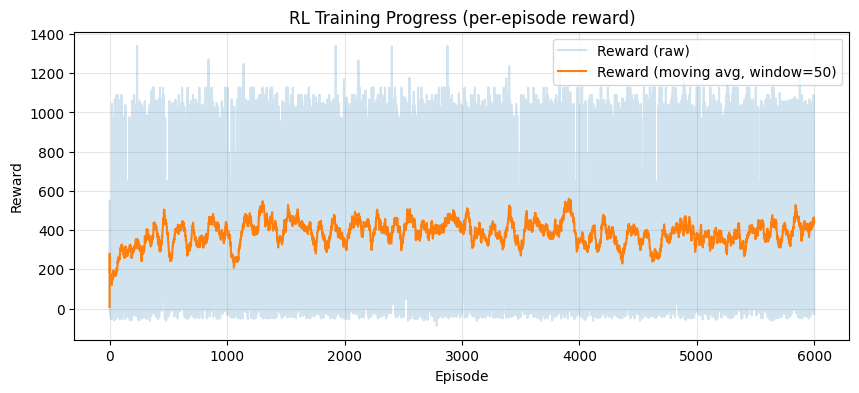

In [2]:
import importlib.util
import matplotlib.pyplot as plt

# 1) Load the final engine
spec = importlib.util.spec_from_file_location("rl_engine_final", "/content/rl_engine_final.py")
rlmod = importlib.util.module_from_spec(spec)
spec.loader.exec_module(rlmod)

# 2) Monkey-patch train() to record reward per episode
orig_train = rlmod.RLRelocator.train  # keep original

def train_with_history(self, episodes=6000, alpha=0.25, epsilon=1.0, epsilon_decay=0.996, epsilon_min=0.06):
    items = self.parts[self.parts["BOXES_ON_HAND"] > 0]["ITEM_ID"].astype(str).tolist()
    if not items:
        raise ValueError("No items with BOXES_ON_HAND > 0. Cannot train.")

    loc_ids = self.loc["loc_inst_code"].astype(str).tolist()
    history = []

    for ep in range(int(episodes)):
        item_id = str(random.choice(items))
        state = self._get_state(item_id)

        # epsilon-greedy zone action
        if random.random() < epsilon:
            a_idx = random.randrange(len(self.actions))
        else:
            a_idx = int(np.argmax(self._Q_row(state)))
        action = self.actions[a_idx]

        # random occupancy snapshot (single SKU per bin)
        bin_sku_map = {l: None for l in loc_ids}
        bin_qty_map = {l: 0 for l in loc_ids}

        occ_n = max(0, int(0.15 * len(loc_ids)))
        occ_bins = random.sample(loc_ids, k=occ_n)

        for b in occ_bins:
            sku = str(random.choice(items))
            if bin_sku_map[b] is not None:
                continue

            loc_row = self.loc_dict[str(b)] if hasattr(self, "loc_dict") else self.loc_idx.loc[str(b)]
            part_row = self.part_dict[str(sku)] if hasattr(self, "part_dict") else self.part_idx.loc[str(sku)]

            if bool(part_row["IS_HEAVY"]) and float(loc_row["z"]) > 1500.0:
                continue

            geom1 = geom_solve_capacity_and_layout(loc_row, part_row, qty=1)
            if geom1 is None:
                continue

            max_units = int(geom1["MAX_UNITS"])
            if max_units <= 0:
                continue

            qty = random.randint(1, min(3, max_units))
            bin_sku_map[b] = sku
            bin_qty_map[b] = qty

        best = self._pick_best_bin_for_action(item_id, action, bin_sku_map, bin_qty_map, search_cap=180)

        q = self._Q_row(state)[a_idx]
        if best is None:
            reward = -5.0
            self._Q_row(state)[a_idx] = q + alpha * (reward - q)
        else:
            _, _, reward = best
            self._Q_row(state)[a_idx] = q + alpha * (reward - q)

        history.append(float(reward))
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

    self.training_history = history
    return self.Q

# Replace train at runtime (file stays unchanged)
rlmod.RLRelocator.train = train_with_history

print("Patched: RLRelocator.train now records training_history (file unchanged).")

df_loc_raw   = read_csv_semicolon_if_needed(LOCATIONS_FILE)
df_parts_raw = read_csv_semicolon_if_needed(PARTS_FILE)
df_alloc_raw = read_csv_semicolon_if_needed(ALLOC_BASELINE_FILE)

df_loc   = normalize_locations(df_loc_raw)
df_parts = normalize_parts(df_parts_raw)
df_alloc_baseline = normalize_allocations_baseline(df_alloc_raw)

df_parts = apply_dynamic_abc(df_parts)
df_loc, entrance, max_dist_possible, max_x_dim = build_guide_zones(df_loc)

rl = rlmod.RLRelocator(df_parts, df_loc, df_alloc_baseline, entrance, max_dist_possible, max_x_dim)
rl.train(episodes=6000, alpha=0.25, epsilon=1.0, epsilon_decay=0.996, epsilon_min=0.06)

# 4) Plot training curve
hist = rl.training_history
window = 50
smooth = [
    sum(hist[max(0, i-window+1):i+1]) / len(hist[max(0, i-window+1):i+1])
    for i in range(len(hist))
]

plt.figure(figsize=(10,4))
plt.plot(hist, alpha=0.2, label="Reward (raw)")
plt.plot(smooth, label=f"Reward (moving avg, window={window})")
plt.title("RL Training Progress (per-episode reward)")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
